# **Bitcoin Turtle Trading Strategy Exploration**

### Description

This project is an exploration of a very simplified version of the famous [Turtle](http://www.turtletrader.com/)
trading strategy done on the Bitcoin price data.  The strategy consists of looking
at the past 4 weeks of price data and calculating the total range.  If price exceeds
the high of the range at any point on a given day a hypothetical long trade is
entered from a price level just above the range high.  We then calculate the difference
in this entry price and the closing price of Bitcoin 4 weeks later.  The analysis
is then done on these differences to determine if breaking out above a 4 week high
price leads to higher prices 4 weeks later.

### Data

The dataset is cryptocurrency daily price data from [Coinmarketcap.com](https://coinmarketcap.com/), aggregated at [Kaggle.com](https://www.kaggle.com/)

https://www.kaggle.com/philmohun/cryptocurrency-financial-data

## Import the data

The full dataset is made up of 200 cryptocurrencies and provides detailed price, volume, and market cap data for each over varying dates, depending on the coin itself.  The first 4 rows are all repeats of the column headers so we can omit.    

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

In [2]:
% matplotlib inline

In [7]:
# Read in all data and inspect
df_all = pd.read_csv('consolidated_coin_data.csv', skiprows=4, low_memory=False)
df_all.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,0x,"Feb 11, 2018",1.09,1.09,0.934155,0.979054,"4,888,770","555,363,000"
1,0x,"Feb 10, 2018",1.14,1.20,0.985705,1.10,"10,828,700","576,535,000"
2,0x,"Feb 09, 2018",1.08,1.15,1.01,1.14,"5,979,420","545,842,000"
3,0x,"Feb 08, 2018",0.988963,1.13,0.988963,1.07,"12,992,800","501,142,000"
4,0x,"Feb 07, 2018",1.01,1.16,0.902145,0.993355,"13,476,600","513,163,000"


In [9]:
df_all.dtypes

Currency      object
Date          object
Open          object
High          object
Low           object
Close         object
Volume        object
Market Cap    object
dtype: object

## Clean the data

A couple things to note here.  First of all, for our purposes we will only need to look at Bitcoin price data, specifically the columns Currency, Date, Open, High, Low and Close.  Also, we notice that the `dtype` for each column is `object` so we know well need to cast to `float` before performing computations on the data.

In [119]:
# Create a dataframe of only Bitcoin and the columns of interest
df_btc = df_all[df_all.Currency == 'bitcoin']
df_btc = df_btc[['Currency', 'Date', 'Open','High', 'Low', 'Close']]

# Make Date a datetime object and set as index
df_btc.Date = pd.to_datetime(df_btc.Date)
df_btc = df_btc.set_index('Date')

# Cast price data columns to floats
df_btc.Open = df_btc.Open.apply(pd.to_numeric)
df_btc.High = df_btc.High.apply(pd.to_numeric)
df_btc.Low = df_btc.Low.apply(pd.to_numeric)
df_btc.Close = df_btc.Close.apply(pd.to_numeric)

# Sort data in ascending order
df_btc.sort_index(axis=0, ascending=True, inplace=True)
df_btc.head()

,Currency,Open,High,Low,Close
Date,,,,,
2013-04-28,bitcoin,135.30,135.98,132.10,134.21
2013-04-29,bitcoin,134.44,147.49,134.00,144.54
2013-04-30,bitcoin,144.00,146.93,134.05,139.00
2013-05-01,bitcoin,139.00,139.89,107.72,116.99
2013-05-02,bitcoin,116.38,125.60,92.28,105.21


In [120]:
df_btc.describe()

,Open,High,Low,Close
count,1751.000000,1751.000000,1751.000000,1751.000000
mean,1436.689475,1491.354038,1376.062067,1441.005945
std,2895.613276,3033.574104,2723.897810,2899.302845
min,68.500000,74.560000,65.530000,68.430000
25%,274.130000,278.830000,267.865000,274.410000
50%,479.120000,492.370000,468.790000,479.000000
75%,856.115000,881.725000,824.280000,860.205000
max,19475.800000,20089.000000,18974.100000,19497.400000


In [26]:
df_btc.dtypes

Currency     object
Open        float64
High        float64
Low         float64
Close       float64
dtype: object

## General Price Visualization

Now that we have the data we want, we can take a look at a general price chart over the entire time period.

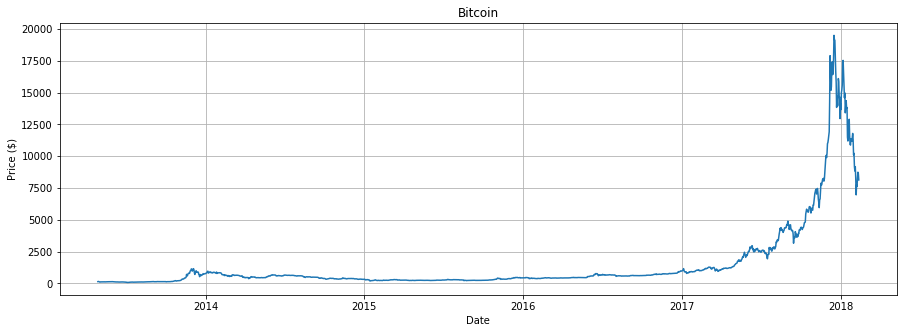

In [121]:
# Generate a plot of closing price over time
plt.figure(figsize=(15,5))
plt.plot(df_btc.index, df_btc.Close)

# Set title and labels
plt.title('Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid()

plt.show()

Now lets get a closer look at a smaller slice of time where we can see the High and Low plotted as well

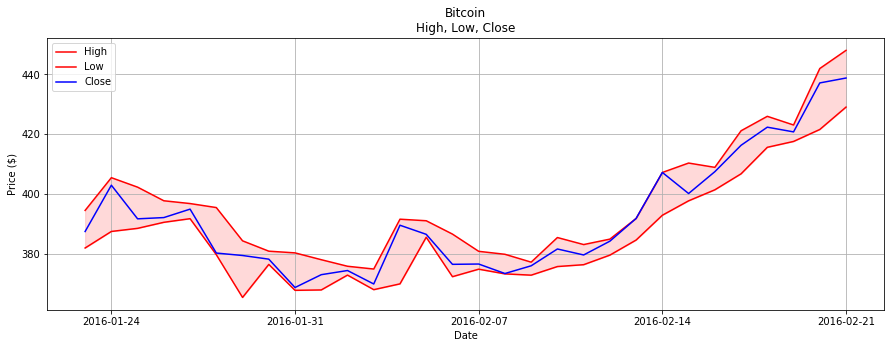

In [288]:
# Pick a smaller window of time and plot High, Low, and Close
plt.figure(figsize=(15,5))

plt.plot(df_btc.index[1000:1030], df_btc.High[1000:1030], color='r', label='High')
plt.plot(df_btc.index[1000:1030], df_btc.Low[1000:1030], color='r', label='Low')
plt.plot(df_btc.index[1000:1030], df_btc.Close[1000:1030], color='b', label='Close')

# Set title, label, legend, and add fill for range
plt.title('Bitcoin\nHigh, Low, Close')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.fill_between(df_btc.index[1000:1030], df_btc.High[1000:1030], df_btc.Low[1000:1030], color='r', alpha=0.15)
plt.legend(loc='best')

plt.grid()
plt.show()

## Create new columns of interest (28-day High, 28-day Low)

In order to examine the simplified Turtle trading strategy we need to create two new rows of data, one for the **28-day High** and one for the **28-day Low**.  

In [126]:
# Create new columns in our dataframe for 28-day high and low
df_btc['High_28_day'] = df_btc['High'].rolling(window=28).max().shift(1)
df_btc['Low_28_day'] = df_btc['Low'].rolling(window=28).min().shift(1)

df_btc.tail()

,Currency,Open,High,Low,Close,High_28_day,Low_28_day
Date,,,,,,,
2018-02-07,bitcoin,7755.49,8509.11,7236.79,7621.30,15018.8,6048.26
2018-02-08,bitcoin,7637.86,8558.77,7637.86,8265.59,15018.8,6048.26
2018-02-09,bitcoin,8271.84,8736.98,7884.71,8736.98,14659.5,6048.26
2018-02-10,bitcoin,8720.08,9122.55,8295.47,8621.90,14659.5,6048.26
2018-02-11,bitcoin,8616.13,8616.13,7931.10,8129.97,14511.8,6048.26


Now lets look at the same small window we did before only with the High price plotted with the 28-day High/Low range.

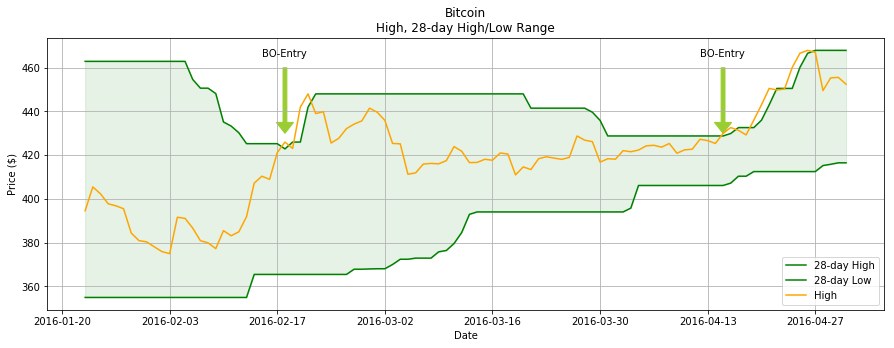

In [325]:
# Generate a plot on the smaller window of time from before of Close and 28-day High/Low range
plt.figure(figsize=(15,5))

plt.plot(df_btc.index[1000:1100], df_btc.High_28_day[1000:1100], color='g', label='28-day High')
plt.plot(df_btc.index[1000:1100], df_btc.Low_28_day[1000:1100], color='g', label='28-day Low')
plt.plot(df_btc.index[1000:1100], df_btc.High[1000:1100], color='orange', label='High')

# Set title, lables, legend, add fill between range
plt.title('Bitcoin\nHigh, 28-day High/Low Range')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.fill_between(df_btc.index[1000:1100], df_btc.High_28_day[1000:1100], df_btc.Low_28_day[1000:1100], color='g', alpha=0.1)
plt.legend(loc='best')

# Show example break-outs above the range
plt.arrow('2016-02-18', 460, 0, -25, width=0.5, head_width=2.25, head_length=5.0, color='yellowgreen')
plt.annotate('BO-Entry', ('2016-02-15', 465))
plt.arrow('2016-04-15', 460, 0, -25, width=0.5, head_width=2.25, head_length=5.0, color='yellowgreen')
plt.annotate('BO-Entry', ('2016-04-12', 465))

plt.grid()
plt.show()

In [294]:
df_btc.iloc[1000:1100][df_btc.High > df_btc.High_28_day]

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Currency,Open,High,Low,Close,High_28_day,Low_28_day
Date,,,,,,,
2016-02-18,bitcoin,416.57,426.00,415.64,422.37,422.88,365.45
2016-02-20,bitcoin,421.60,441.98,421.60,437.16,426.00,365.45
2016-02-21,bitcoin,437.77,448.05,429.08,438.80,441.98,365.45
2016-04-15,bitcoin,424.43,429.93,424.43,429.71,428.80,406.14
2016-04-16,bitcoin,429.57,432.63,428.98,430.57,429.93,407.23
2016-04-19,bitcoin,428.70,436.02,428.10,435.51,432.63,412.50
2016-04-20,bitcoin,435.32,443.05,434.41,441.39,436.02,412.50
2016-04-21,bitcoin,441.42,450.55,440.95,449.43,443.05,412.50
2016-04-24,bitcoin,450.56,460.15,448.93,458.56,450.55,412.50


In [295]:
df_btc.loc['2016-02-18']

Currency       bitcoin
Open            416.57
High               426
Low             415.64
Close           422.37
High_28_day     422.88
Low_28_day      365.45
Name: 2016-02-18 00:00:00, dtype: object

So we see here that the green range is the 28-day High/Low and the orange line is the High for the day.  So the signals we are looking for are anytime the orange line breaks above the green line.  This is our entry point for the trading strategy.

## Generate hypothetical trade data

Now that we have the data we need and have gotten to take a look at it in a few general ways, lets create the data that we need in order to test the actual trading strategy.  The end goal is to have a list of price changes from each entry point as described above, to a period in time 28 days later.  That way we can see if break outs above the 28-day high are leading to higher prices.

In [242]:
from pandas.tseries.offsets import *

# Dataframe of potential trades because we need 28 days of data after entry
df_trades = df_btc[:-28]

# Get a series of hypothetical entry prices
entry_prices = df_trades[df_trades.High > df_trades.High_28_day].High + 1

# Create a series of exit prices based off closing price 28 days after entry date
exit_dates = entry_prices.index + DateOffset(days=28)

exit_prices = []

for i in range(len(exit_dates)):
    exit_prices.append(df_btc.loc[exit_dates[i]].Close)

# Generate the final list of price differences
exit_prices_array = np.array(exit_prices)
price_diffs = exit_prices_array - entry_prices

# Save number of trades and average price diff
trade_count = len(price_diffs)
ave_price_diff = price_diffs.mean()

print('Number of Trades: {}'.format(trade_count))
print('Average price diff: {}'.format(ave_price_diff))

Number of Trades: 235
Average price diff: 592.816


So over the entire period we counted **235** trades with the average price change being **$592.82**

## Statistical Testing 

We now have the data we want and the sample mean.  It is time to pose the hypothesis and test it.

### Define Null and Alternative Hypotheses

  * *Null Hypothesis:* Price change is random and therefore any mean of sample price differences is zero.
  * *Alternative Hypothesis:* A breakout above a 28-day high leads to higher prices and therefore the mean of the sample of price differences is significantly greater than zero. 

### Check data for Normal Distribution

In this example our underlying assumption is that price change is random and therefore is normally distributed.  We want to test whether our sample data falls in line with our assumption.  Here is a bar chart of the sample data so we can quickly inspect whether or not we believe it is normally distributed before applying the test.

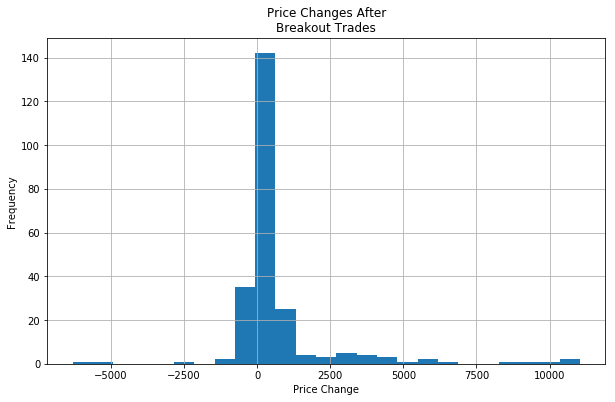

In [243]:
# Generate a bar chart of the sample data
plt.figure(figsize=(10,6))

plt.hist(price_diffs, bins=25)

# Set title and labels
plt.title('Price Changes After\nBreakout Trades')
plt.xlabel('Price Change')
plt.ylabel('Frequency')

plt.grid()
plt.show()

Because of the significant outliers it doesnt appear that the data is normally distributed.  Confirm this below with a Kolmogorov–Smirnov Test for goodness-of-fit.

In [244]:
# Fit mean and std of the data to normal dist
mean, std = stats.norm.fit(price_diffs)

# Create Normal dist and test 
n = stats.norm(loc=mean, scale=std)
stats.kstest(price_diffs, n.cdf)

KstestResult(statistic=0.28005054310286659, pvalue=0.0)

The low test-statistic and p-value make it clear that this data does not follow the normal distribution and thus we cannot use a t-test here.

### Perform the test

So we have to find another test to use and it this case I believe the Wilcoxon rank-sum test is appropriate.  It tests whether two sets of measurements are drawn from the same distribution.  In this case the **first set** would be the hypothetical set of **235** trades that had **$0** price change after 28 days.  The **second set** is our data.

In [273]:
np.random.seed(0)

# Create a list of random price changes with mean 0, same size and standard dev as our sample
price_diffs_0 = np.random.randn(len(price_diffs)) * price_diffs.std() 

# Rank-sums test
t_stat, p_value = stats.ranksums(price_diffs, price_diffs_0)

print('Test-statistic: {}'.format(t_stat))
print('p-value: {}'.format(p_value))

Test-statistic: 2.2499257913182964
p-value: 0.024453656418820857


### Summarize results

Given the positive test statistic and p-value below 0.05 we **reject the null hypothesis** that the two samples came from the same distribution.  Because this is a two-sided test the positive statistic shows that after entry of our sample trades the price of Bitcoin did tend to rise in the next 28 days.

By visually inspecting the data this seems to be confirmed.  However, for me personally, it is quite surprising to see the results not skewed even more to the positive side.  This is a market that has been in a clear uptrend and when it does go, it moves violently.  The high variance is certainly expected and seeing some of the significant price changes over the course of these four-week periods gives clear confirmation that this is an extremely volatile market.

## Further Exploration

There are a number of places to go from here as far as continuing and improving the analysis in order to make some real trading decisions down the road.  I will list a few here and hopefully explore them soon or as part of future projects.

1. What about the short side of things?  This analysis only took into account long trades for simplicity but it would be interesting to see if break-outs below the lows of the range showed similar results.

2.  The real Turtle traders used a breakout system similar to this one to determine their entry points into the market.  However, entry point is only one of many aspects that make up a real trading plan.  I want to further explore setting risk and profit targets based on price volatility and then seeing what the overall expected value of the trading strategy would be.  

3.  Why confine the results to Bitcoin?  A robust trading strategy should be able to show positive expectancy for other cryptocurrencies, stocks, commodities, etc.  Abstracting this study and then using it on other products is a real world project that I'm sure many people are pursuing with all kinds of strategies right now.